In [39]:
import glob as gl
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import scikit_posthocs as sp
from scipy.stats import ks_2samp, kruskal,ttest_ind,spearmanr,pearsonr
from scipy import stats
import seaborn as sns
import shutil

In [40]:
# All metadata
in_folder = "./Protein_data"


# treatments_c = {"Met":1,"AHA":2,"cLTP":3}
treatments = ["Met","AHA","cLTP"]
x_labels = ["Met","Basal","cLTP"]
treat_folders = {treatments[2]:"cLTP",treatments[0]:"CTL_MET",treatments[1]:"CTL_AHA"}
cltp_folder = os.path.join(in_folder,treat_folders[treatments[2]])
met_folder = os.path.join(in_folder,treat_folders[treatments[0]])
aha_folder = os.path.join(in_folder,treat_folders[treatments[1]])
compartments = ["soma","dendrite"]
CNIH2_ls_file = os.path.join(in_folder,"CNIH2_LTP_ls_punctas.pkl")
CNIH2_ls_meta_file = os.path.join(in_folder,"CNIH2_LTP_ls_meta.pkl")

In [41]:
op_folder = "../Figures/CNIH2_local_synthesis"
def CreateFolderRecursive(folder):
    """
        function creates folders upto  a path recursively
        arguments : folderpath
    """
    Path(folder).mkdir(parents=True, exist_ok=True)
CreateFolderRecursive(op_folder)

In [42]:
CNIH_ls_data = pd.read_pickle(CNIH2_ls_file)
CNIH_ls_meta_data = pd.read_pickle(CNIH2_ls_meta_file)
cell_data = CNIH_ls_data.groupby(["cell_id","treatment","compartment"])
cell_meta_data = CNIH_ls_meta_data.groupby(["cell_id","treatment","compartment"])

In [43]:
newprot_counts = CNIH_ls_data.groupby(["cell_id","treatment","compartment"]).count().PID
# newprot_counts.PID

In [44]:
ROI_areas = cell_meta_data.sum().ROI_AOL
ROI_areas

cell_id  treatment  compartment
1        cLTP       dendrite       302.467955
                    soma            58.633183
6        AHA        dendrite       287.298083
                    soma            79.103049
9        AHA        dendrite       357.500957
                                      ...    
38       AHA        soma            24.272851
39       AHA        dendrite       882.136707
                    soma            12.805324
40       AHA        dendrite       452.031427
                    soma            12.735636
Name: ROI_AOL, Length: 104, dtype: float64

# Dividing the puncta counts by Area (for somatic) and Length (for dendritic) for calculating puncta density

In [45]:
newprot_density = newprot_counts/ROI_areas
# newprot_density = newprot_density.dropna()
# newprot_density 
newprot_density = newprot_density.reset_index()
newprot_density = newprot_density.rename(columns={0:'Density'})
newprot_density['Density'].fillna(value = 0,  inplace = True)
newprot_density["Density"] = newprot_density["Density"] 
# newprot_counts = newprot_counts.


In [46]:
newprot_density.head()

,cell_id,treatment,compartment,Density
0,1,cLTP,dendrite,0.254572
1,1,cLTP,soma,0.596932
2,6,AHA,dendrite,0.052211
3,6,AHA,soma,0.037925
4,9,AHA,dendrite,0.055944


In [47]:
cell_data.size(),cell_meta_data.size()

(cell_id  treatment  compartment
 1        cLTP       dendrite        77
                     soma            35
 6        AHA        dendrite        15
                     soma             3
 9        AHA        dendrite        20
                                   ... 
 38       AHA        soma           210
 39       AHA        dendrite       100
                     soma            66
 40       AHA        dendrite       143
                     soma            81
 Length: 103, dtype: int64,
 cell_id  treatment  compartment
 1        cLTP       dendrite       10
                     soma            1
 6        AHA        dendrite       20
                     soma            1
 9        AHA        dendrite       14
                                    ..
 38       AHA        soma            1
 39       AHA        dendrite       17
                     soma            1
 40       AHA        dendrite       25
                     soma            1
 Length: 104, dtype: int64)

## Utility function to generate and save the plot

In [48]:
def SaveFigures(filename,ext_list = [".png",".svg",".pdf"],dpi=300):
    """
        function to save figures
        required arguments:
            filename
    """
    plt.tight_layout()
    for ext in ext_list:
        plt.savefig(filename+ext,dpi=dpi)
def AnnotateText(ax,x1,x2,y,h,txt,color,ha='center',va='bottom',fsize=24):
        # print(x,y,txt)
        if not txt == '':
            fac = np.abs(x2-x1)*0.04
            trans = ax.get_xaxis_transform()
            plt.hlines(xmin=x1,xmax=x2, y = y+fac, lw=1.5, color=color)#, transform=trans)
            plt.text((x1+ x2)*0.5,y+h+fac,txt, ha=ha, va=va, color=color,fontsize=fsize)#,transform=trans )
def SwarmBoxCombo(dp,x,y,fbase,xlabel,ylabel,title,Num=True,pairs = [[1,2]]):
    # for compa in compartments:
        fig,ax = plt.subplots(figsize=(8,6),nrows=1, ncols=1)
        xfsize = 26
        ax.tick_params(axis='both', which='major', labelsize=xfsize)
        ax.grid(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        # comp_to_analyse = compa
        # order = reversed(treatments)
        print(dp.shape)
        hue = "treatment"
        hue_order = treatments[1:]
        print(hue_order)
        color_pal = ['k','k']
        data_to_plot = dp#dp[dp["compartment"]==comp_to_analyse]
        hue_plot_params = {
                    'data': data_to_plot,
                    'x': x,
                    'y': y,
                    # "order": order,
                    "hue": hue,
                    "hue_order": hue_order,
                    "palette": color_pal,

                }
        # pairs = [
        #     (('E6',tool_list[0]),('E6',tool_list[1])),
        #     (('E7',tool_list[0]),('E7',tool_list[1]))
        #         ]
        sns.swarmplot(**hue_plot_params,
                      dodge=True,
                      zorder=1,
                      size = 10,
                      # kind="strip",
                      # native_scale=True,
                      alpha = 0.5,
                      edgecolor = "k",
                      linewidth = 2,
                      ax=ax)
        sns.boxplot(**hue_plot_params,
                    fill=False,
                    showmeans=True ,
                    meanprops={"marker": "^",
                       "markeredgecolor": "k",
                       "markerfacecolor":"k",
                       "markersize": "20"},
                    medianprops={'color': '#7c0cb4ff', 'ls': '-', 'lw': 4},
                    # width=0.2,
                    zorder=3,
                    showfliers=True,
                    # gap=2.8,
                    ax=ax)
        
        if Num:
            comp_data = np.array(data_to_plot.groupby(["treatment"]).Num.apply(list))#.to_numpy()
            print(data_to_plot.groupby(["treatment"]).Num.median())
            # ax.set_ylim([0.2,1])
        else:
            # print(data_to_plot.head())
            comp_data = np.array(data_to_plot.groupby(["treatment"]).Density.apply(list))#.to_numpy()
            print(data_to_plot.groupby(["treatment"]).Density.median())
        x_poss = [-0.2,0.2]
        
        x_pairs = [[-0.2,0.2],[0,0.25]]
        print(comp_data)
        # print(ymax)
        for pdx,pair in enumerate(pairs):
            ks_res = stats.mannwhitneyu(comp_data[pair[0]-1], comp_data[pair[1]-1])
            print(ks_res.statistic,ks_res.pvalue,comp_data.shape)
            # print(p_values[p[0]][p[1]])
            txt = ''
            ymax = np.max([np.max(comp_data[pdx*1+pdx])*1.1,1])
            print(ks_res.pvalue)
            if ks_res.pvalue > 0.05:
                txt= "ns"
            else:
                
                if ks_res.pvalue <= 0.05:
                    txt += '*'
                if ks_res.pvalue <= 0.01:
                    txt += '*'
                if ks_res.pvalue <= 0.001:
                    txt += '*'
            print(txt)
            AnnotateText(ax,x_pairs[pdx][0],x_pairs[pdx][1],ymax+0.1*pdx,0.01,txt,'k')
        ax.set_xlabel(xlabel,fontsize=xfsize)
        ax.set_ylabel(ylabel,fontsize=xfsize)
        ax.set_xticks(x_poss,x_labels[1:],rotation=45)
        ax.set_title(title,fontsize=xfsize)
        # ax.set_xlim([-0.4,0.4])
        plt.legend([],[],frameon=False)
        plt.gca().set_ylim(bottom=0)
        SaveFigures("{}/{}".format(op_folder,fbase))
        # annotator = Annotator(ax,pairs=pairs,**hue_plot_params)
        # annotator.configure(test=stat_test, fontsize = xfsize)
        # annotator.apply_and_annotate()
        # sns.swarmplot(data=mRNA_fractions[mRNA_fractions["compartment"]=='neurite'],x="isoform",y='fractions',dodge=True,ax=ax)

        

(52, 4)
['AHA', 'cLTP']
treatment
AHA     4.984875
cLTP    5.289257
Name: Density, dtype: float64
[list([0.037925213319097935, 0.051140054841132404, 0.15620602739841202, 0.11171783044044885, 0.0, 0.14964923118662682, 0.17280646058486848, 0.10057322319947541, 0.0851452522268739, 0.05250540066441603, 8.58538957446173, 7.087191377774737, 4.417170909969953, 6.337328482509102, 4.8156439874327575, 3.4315855828924677, 7.127010393989042, 7.430874901984985, 4.272693324942902, 7.552031314784302, 9.056238288062408, 7.528180217344428, 9.21158648879295, 5.757862456259837, 1.6968615256468398, 5.827389914319131, 7.7833557348579, 8.651641128610935, 5.154106073072643, 6.360106642216552])
 list([0.5969316032943154, 0.09841855992566026, 0.2536598725156739, 0.19772529497108177, 0.22479173408066036, 8.333809431565841, 2.1241618591091176, 5.008863882596697, 7.838786475897908, 2.919817222445115, 2.17865959366282, 8.364510708233995, 5.056558747314429, 7.834059348406886, 6.996524446323854, 5.797969739779024, 9

/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_19860/2487173521.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_19860/2487173521.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


(52, 4)
['AHA', 'cLTP']
treatment
AHA     0.202858
cLTP    0.392137
Name: Density, dtype: float64
[list([0.052210581595407514, 0.055943906231511395, 0.012035937327595808, 0.0318055094209454, 0.07421695508949738, 0.09223594508642104, 0.027398041786007066, 0.05161798499338702, 0.13469472508644104, 0.0634311190705195, 0.17530164597377818, 0.3171325883078246, 0.2015988042737416, 0.37958942426905257, 0.6468088041953944, 0.39489158648672584, 0.7037250976908407, 0.2944201956853846, 0.15184359069178122, 0.4887399059210693, 0.5901798997003046, 0.15517889323051828, 0.5466011496380582, 0.45705005016850586, 0.2041177626329998, 0.7012343386125213, 0.6756028374738852, 0.29387758629028, 0.11336111428098991, 0.3163496862848728])
 list([0.25457242254266826, 0.18307395773166676, 0.18108944396255464, 0.479392597103104, 0.0770858395866597, 0.8237966614081825, 0.21957885201712898, 0.32472618320185354, 0.43935100675343547, 0.5927639476051857, 0.048778332761089074, 0.553011415119029, 0.4022989744660739, 0.40

/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_19860/2487173521.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()
/var/folders/d6/hjzjt_zj445gbm3zrwpyf_880000gn/T/ipykernel_19860/2487173521.py:7: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.tight_layout()


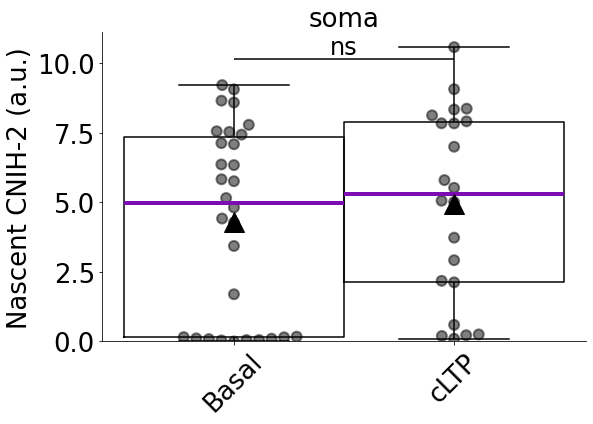

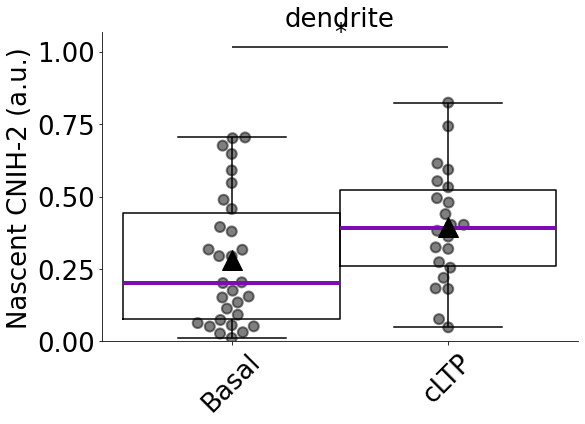

In [49]:
# compart = compartments[0]
unit_string = {compartments[0]:" \n in {} / $\mu m^2$".format(compartments[0]),compartments[1]:"\n in {} / $ \mu m$".format(compartments[1])}
for compart in compartments:
    xlab = ""
    title = "{}".format(compart)
    ylab = r"Nascent CNIH-2 (a.u.)"
    SwarmBoxCombo(newprot_density[newprot_density.compartment==compart],
                  x = "compartment",
                  y = "Density",
                  fbase="Fig_cLTP_new_cnih2_{}_density".format(compart),
                  xlabel=xlab,
                  ylabel=ylab,
                  title=title,
                  Num = False)
    
